# Deux conteneurs
## Scénario réaliste
### Changer la soft limite pendant l'exécution
#### Description
Cette expérience fait suite à la précedent exécutant le scénario où un conteneur reçoit un pic de requête tandis que l'autre est inactif.

Cette expérience a montré que pour garantir les performances du conteneur recevant le pic de requête il fallait intervenir.
Cette intervention se fera en modifiant la valeur de `soft` limite des conteneurs au cours du scénario. Cette valeur sera modifiée ainsi :
1. 5 secondes après le début de la première partie le conteneur recevant le pic de requête verra sa `soft` limite fixée à 2.5GB et celle du conteneur peu actif sera mise à .5GB.
2. 5 secondes après le début de la deuxième partie, les `soft` limites seront inversées car l'activité des conteneurs s'inversent.
3. 5 secondes après le début de la troisième partie, les conteneurs verront leurs `soft` limites fixées à 2GB car ils reçoivent tous les deux un pic de requête.

#### Environnement 
Les conteneurs ont été lancés dans une machine virtuelle linux 4.19.5 disposant de 3GB de mémoire et 4 coeurs.

Les accès au disque de la machine virtuelle ne pouvaient pas compter sur le cache fichier du système hôte car celui-ci a été désactivé.

Chaque conteneur est lancé avec une `max` limite fixée à 3GB et une `soft` limite fixée à 2GB. Chaque conteneur dispose de deux coeurs. 

Les différentes exécutions n'ont pas d'impact les unes sur les autres car le cache fichier est vidé entre chaque itération.

#### Résultats attendus
Pour les différentes parties du scénario il est possible d'attendre les comportements suivants :
1. Le conteneur A recevant le pic de requête devrait mieux y faire face et devrait être capable de traiter environ 1000 événements par seconde. Le conteneur B devrait par contre arriver à traiter les 100 événéments qu'il reçoit chaque seconde.
2. Grâce à la modification de sa `soft` limite le conteneur B devrait pouvoir traiter environ 1000 événéments. Le conteneur A devrait être capable de traiter les 100 énévements lui arrivant chaque seconde.
3. Aucun des deux conteneurs ne pourra gérer les 1000 énévements arrivant chaque seconde.

#### Algorithme de l'expérience
Les expériences ont été répétées 10 fois afin de calculer une moyenne et l'écart-type associé.

Avant chaque expérience une sauvegarde de la base de données est effectuée afin de ramener celle-ci de force en mémoire et donc de gonfler la mémoire du conteneur.
Cette sauvegarde ramenera les données dans le cache fichier du noyau. Ainsi pour accèder à ces données `mysql` n'aura qu'à faire une copie de celles-ci depuis le cache fichier vers son tampon mémoire plutôt que ramener celles-ci depuis le disque.
Cette sauvegarde émule en quelque sorte le fait que `mysql` s'exécute depuis longtemps et à ramener toute la base de données dans sa mémoire.

Le script permettant de lancer plusieurs conteneurs en même temps et d'obtenir des statistiques sur ceux-ci est le suivant :
```python
#! /usr/bin/env python3
# SPDX-License-Identifier: MPL-2.0
# Copyright (c) 2019 Francis Laniel <francis.laniel@lip6.fr>
import sys
import docker
import os
import threading
import json
import time


"""This python script will start two containers with filebench with the given as
argument soft limits.

It will then run 10 times the SYSBENCH_CONTAINER_A and SYSBENCH_CONTAINER_B in
each container as argument. The output of filebench will be written to a file
and statistics (memory usage in bytes and reads from the disk) will be written
to another file.
"""

# Each run lasts 180 seconds.
DURATION = 180

CHARS = ['A', 'B']

# Containers' DB will be 2G.
# Each will execute with two threads since they have 2 cores.
SYSBENCH_PREPARE_COMMAND = 'sysbench --threads=2 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 prepare'

# Each experiment will be composed of 3 sysbenchs execution:
# 1. A will execute sysbench at 1000 event per second (near the unlimited rate)
# and B will limit the rate event to 100 (it is 10% of the
# unlimited rate).
# 2. This case is case 1 reversed.
# 3. A and B will run sysbench at the same rate of 1000 events per second.
SYSBENCH_RUN_COMMANDS = {'A' : ['sysbench --report-interval=1 --time=60 --threads=2 --rate=1000 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=100 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=1000 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run'], 'B' : ['sysbench --report-interval=1 --time=60 --threads=2 --rate=100 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=1000 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run', 'sysbench --report-interval=1 --time=60 --threads=2 --rate=1000 /usr/share/sysbench/oltp_read_only.lua --table_size=10000000 run']}

# This command is run before each run to force read the whole database and bring
# it in memory.
# WARNING We can not use redirection directly in exec_run. We need to use bash
# to be able to redirect. Thanks Damien for the information and also the
# suggestion of the command.
MYSQL_DUMP_COMMAND = "bash -c 'mysqldump sbtest > /dev/null'"

# Give two virtual core to each container. The virtual core are chosen so they
# are on the same physical core (i.e cache are shared).
CONTAINERS_CPUS_SETS = ['0,2', '1,3']

# Those keys are stored under the stat json object in the memory_stats object.
MEMORY_KEYS = ['active_anon', 'active_file', 'inactive_anon', 'inactive_file', 'unevictable']

# 'io_serviced_recursive' gives the number of read, write, etc. while
# 'io_service_bytes_recursive' gives the number of bytes read, written, etc.
IO_KEYS = ['io_serviced_recursive', 'io_service_bytes_recursive']

# The keys added to a temporary dictionary.
KEYS = ['usage'] + MEMORY_KEYS + ['io_serviced_recursive:Read', 'io_service_bytes_recursive:Read']

# Barrier used to synchronize containers' thread with update_soft_limit thread.
BARRIER = threading.Barrier(3)

def thread_func(container, commands, out, stats):
	"""Run the commands in container and write the output in out.
	This function will be used as a thread.
	:param container: The container in which command will be run. It must already
	been started.
	:type container: docker.models.containers.Container.
	:param commands: The commands to run in container.
	:type commands: list of str.
	:param out: An open in write file object where the output of command will be
	written.
	:type out: _io.TextIOWrapper
	:param stats: An open in write file object where the stats of the container will
	be written.
	:type stats: _io.TextIOWrapper
	"""
	container.exec_run(MYSQL_DUMP_COMMAND)

	# Wait on the BARRIER once MYSQL_DUMP_COMMAND is done.
	ret = BARRIER.wait()

	gen = container.stats()

	for command in commands:
		# Run the benchmark inside the container and write the output to out.
		# exec_run returns a tuple whom second field contains bytes. The decode
		# translate them to a string.
		out.write(container.exec_run(command)[1].decode('utf-8') + '\n')

	statistics = []
	old_values = {}

	# old_values will be used below, this loop initializes it with 0s and
	# with the good keys.
	for i in KEYS[1 + len(MEMORY_KEYS):]:
		old_values[i] = 0

	for record in gen:
		# Translate the record in string and translate it to python dictionary.
		# Vive la Joz' ! Bon vivant Docteur bon vivant !
		jason = json.loads(record.decode('utf-8'))

		# Create a new dictionary at each iteration so the statistics's cases are
		# differents.
		chicandier = {'usage': jason['memory_stats']['usage']}

		# Add the interesting memory stats to dictionary.
		for key in MEMORY_KEYS:
			chicandier[key] = jason['memory_stats']['stats'][key]

		for key in IO_KEYS:
			for io in jason['blkio_stats'][key]:
				if io['op'] == 'Read':
					# Reconstruct the key with the jason key and the op.
					true_key = key + ':' + io['op']

					# Get the difference between this iteration and the previous one.
					# The value is the number of read or write for this second. It can be
					# seen as the bandwith.
					val = io['value'] - old_values[true_key]

					# Update the old value. Since it begins at 0 the first value will be
					# quite wrong but I do not think it will be a big problem.
					old_values[true_key] = io['value']

					# Little trick if the key is not already present.
					# TODO Maybe this if is useless since this code is called each second
					# and chicandier is recreated each second. But it works and I will not
					# loose some time for a little branch...
					if true_key in chicandier:
						chicandier[true_key] += val
					else:
						chicandier[true_key] = val

		statistics.append(chicandier)

		# Our filebenches last DURATION seconds so we just want DURATION
		# records since containerd give stats every second.
		if len(statistics) == DURATION:
			break

	# Add the statistics to the stat file.
	for i in range(len(statistics)):
		stats.write('%d' % i)

		# Write each statistics in order.
		for key in KEYS:
			stats.write(';%d' % statistics[i][key])

		stats.write('\n')

def update_soft_limit_csv(t, out, containers):
	"""Write the soft limit of containers for the given time in out.
	:param t: The time in scenario.
	:type t: int.
	:param out: File where soft limits will be written.
	:type out: _io.TextIOWrapper
	:param containers: List of container whom soft limit will be written.
	:type containers: list<docker.models.containers.Container>.
	"""
	api = docker.APIClient()

	out.write('%d' % t)

	for c in containers:
		# Write c's soft limit in out.
		out.write(';%u' % api.inspect_container(c.id)['HostConfig']['MemoryReservation'])

	out.write('\n')

# There will be 3 soft limit update at 5, 65 and 125 seconds in the scenario.
SLEEPS = [5, 60, 60]

# The update value are contained in this list.
UPDATE_SOFT_LIMIT = [['2500M', '500M'], ['500M', '2500M'], ['2G', '2G']]

def update_soft_limit(out, containers):
	"""Update the soft limit of given container to respectively 2.5GB and .5GB.
	This update will be done 5 seconds after the begining of the scenario.
	:param out: Updated soft limit will be written in this file.
	:type out: _io.TextIOWrapper.
	:param containers: List of container whom soft limit will be updated.
	:type container: list<docker.models.containers.Container>.
	"""
	t = 0

	update_soft_limit_csv(t, out, containers)

	# Wait the end of the MYSQL_DUMP_COMMAND.
	ret = BARRIER.wait()

	for i in range(len(SLEEPS)):
		time.sleep(SLEEPS[i])
		t += SLEEPS[i]

		# Update the containers' soft limits.
		for c in range(len(containers)):
			containers[c].update(mem_reservation = UPDATE_SOFT_LIMIT[i][c])

		# Write the new values in out.
		update_soft_limit_csv(t, out, containers)

def main():
	containers = []
	outs = []
	stats = []

	if len(sys.argv) < 2 or len(sys.argv) > 3:
		sys.exit("Usage: %s soft_limit0 [soft_limit1]" % sys.argv[0])

	client = docker.from_env()

	for i in range(len(sys.argv) - 1):
		# Launch containers as detached.
		containers.append(client.containers.run('sysbench', auto_remove = True, detach = True, mem_limit = '3G'))

	# Wait 30 seconds so the sysbench container is ready. Indeed, it can be slow
	# because mysql is long to boot.
	time.sleep(30)

	# Open /proc/sys/vm/drop_caches to be able to drop linux page cache.
	drop_cache = open('/proc/sys/vm/drop_caches', 'wb', buffering = 0)

	# Run each benchmark once so they are prepared.
	for i in range(len(containers)):
		containers[i].exec_run(SYSBENCH_PREPARE_COMMAND)

		# Set the container limits once its preparation phase is finished.
		# sys.argv[i + 1] because sys.argv[0] is the program name and there are
		# len(sys.argv) - 1 containers.
		containers[i].update(mem_reservation = sys.argv[i + 1], mem_limit = '3G', memswap_limit = '3G', cpuset_cpus = CONTAINERS_CPUS_SETS[i])

		# Drop the cache so the preparation above does not have a consequence on the
		# runs below.
		drop_cache.write(bytearray('3\n', 'utf-8'))

		outs.append(open(os.path.expanduser('~/soft_update_container_%c_%s_%s.out' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))
		stats.append(open(os.path.expanduser('~/soft_update_container_%c_%s_%s.stats' % (CHARS[i], containers[i].name, sys.argv[i + 1])), 'w'))

		stats[i].write('iteration;usage;active_anon;active_file;inactive_anon;inactive_file;unevictable;reads;read_bandwith\n')

	# This file will be written by update_soft_limit and will contain soft limits
	# of containers over time.
	fd = open(os.path.expanduser('~/soft_limit.csv'), 'w')
	fd.write('time;soft_limit0;soft_limit1\n')

	# Run each filebench 10 times to compute mean and standard deviation.
	for i in range(10):
		threads = []

		for j in range(len(containers)):
			# Prepare the threads which will run filebench inside the containers.
			threads.append(threading.Thread(target = thread_func, args = (containers[j], SYSBENCH_RUN_COMMANDS[CHARS[j]], outs[j], stats[j])))

		# Add the update_soft_limit thread.
		threads.append(threading.Thread(target = update_soft_limit, args = (fd, containers,)))

		# Launch the threads.
		for t in threads:
			t.start()

		# Wait them.
		for t in threads:
			t.join()

		# Reset soft limit since it was changed by update_soft_limit
		for i in range(len(containers)):
			containers[i].update(mem_reservation = sys.argv[i + 1])

		# Drop the cache between each run so they are independents.
		drop_cache.write(bytearray('3\n', 'utf-8'))

	# Stop and close everything.
	for i in range(len(containers)):
		containers[i].stop()

		outs[i].close()
		stats[i].close()

	fd.close()
	drop_cache.close()

if __name__ == "__main__":
	main()
```

#### Résultats obtenus
Étudions d'abord le nombre de transactions, le nombre de requêtes et la latence de celles-ci au cours du scénario pour les deux conteneurs :

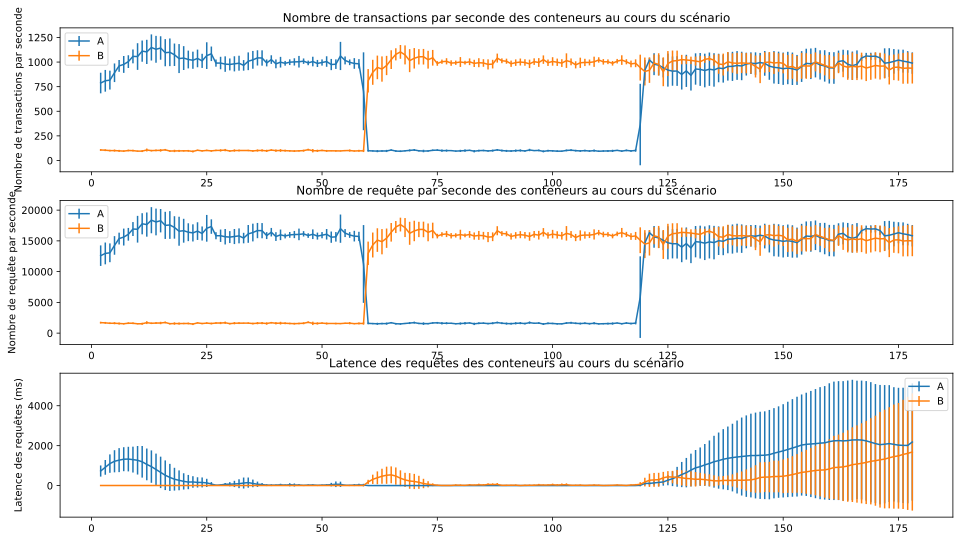

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats


DIR = 'update_soft_limit_5s'
FILES = {'A': ['soft_update_container_A_sad_feynman_2000M.out.time.csv'], 'B': ['soft_update_container_B_keen_lalande_2000M.out.time.csv']}

KEYS = ['transactions', 'queries', 'latencies']

DURATION = 180
NAMES = ['A', 'B']

dictionnary = {}

for key in FILES:
    dictionnary[key] = {}
    
    for k in KEYS:
        dictionnary[key][k] = {}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(KEYS)):
            # The first record has strange standard deviation values so we do not get it.
            # For each key in KEYS there is two columns: the mean and the standard deviation.
            # The mean is the odd column and the standard deviation the even one.
            # The 'i * 2 + x' permits to take the good column for this key.
            dictionnary[key][KEYS[i]]['means'] = values.take(i * 2 + 1, axis = 1)[2 : len(values) - 1]
            dictionnary[key][KEYS[i]]['stds'] = values.take(i * 2 + 2, axis = 1)[2 : len(values) - 1]

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

fig, (transactions_ax, queries_ax, latency_ax) = plt.subplots(nrows = 3, figsize = (16, 9))

for key in sorted(FILES.keys()):
    transactions_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['transactions']['means'], yerr = dictionnary[key]['transactions']['stds'], label = key)
    queries_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['queries']['means'], yerr = dictionnary[key]['queries']['stds'], label = key)
    latency_ax.errorbar(x_pos[2 : len(x_pos) - 1], dictionnary[key]['latencies']['means'], yerr = dictionnary[key]['latencies']['stds'], label = key)

transactions_ax.legend()
transactions_ax.set_ylabel('Nombre de transactions par seconde')
transactions_ax.set_title('Nombre de transactions par seconde des conteneurs au cours du scénario')

queries_ax.legend()
queries_ax.set_ylabel('Nombre de requête par seconde')
queries_ax.set_title('Nombre de requête par seconde des conteneurs au cours du scénario')

latency_ax.legend()
latency_ax.set_ylabel('Latence des requêtes (ms)')
latency_ax.set_title('Latence des requêtes des conteneurs au cours du scénario')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Comparée aux résultats de l'expérience sans modification des `soft` limites on peut voir que les conteneurs semblent atteindre un peu plus rapidement leur taux de transactions demandées.

De plus, la courbe des latences présente une bosse moins importante que sans modification de a `soft` limite.
La modification de celle-ci permet donc d'améliorer légèrement les performances des conteneurs.

Concentrons nous désormais sur les performances globales par parties des conteneurs :

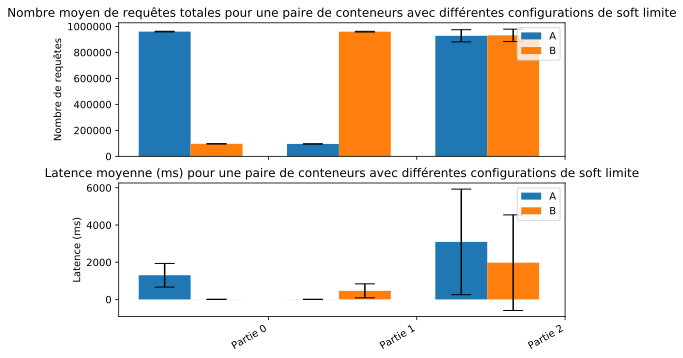

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

DIR = 'update_soft_limit_5s'
FILES = {'A': ['soft_update_container_A_sad_feynman_2000M.out.csv'], 'B': ['soft_update_container_B_keen_lalande_2000M.out.csv']}

# xtick labels for the bar chart.
NAMES = ['Partie 0', 'Partie 1', 'Partie 2']
# The width of the bars.
WIDTH = .35

dictionnary = {}

for key in FILES:
        dictionnary[key] = {'request': {'mean': [], 'std': []}, 'latency': {'mean': [], 'std': []}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        for i in range(len(NAMES)):
            # Computing mean and standard deviation.
            # values is a numpy.ndarray i.e an array of tuples.
            # mean() and std() take an axis as argument and return a tuple.
            # [1] permits to obtain second member of tuple.
            # The queries are the first csv field (+ 1 because of the run column).
            dictionnary[key]['request']['mean'].append(values.mean(0)[1 + i])
            dictionnary[key]['request']['std'].append(values.std(0)[1 + i])
            
            dictionnary[key]['latency']['mean'].append(values.mean(0)[1 + len(NAMES) + i])
            dictionnary[key]['latency']['std'].append(values.std(0)[1 + len(NAMES) + i])

x_pos = np.arange(len(NAMES))

# Axis and figure initialization.
fig, (request_ax, latency_ax) = plt.subplots(nrows = 2, figsize = (8, 6))

request_groups = []
latency_groups = []

# sort the keys so order is correct.
sorted_keys = sorted(FILES.keys())

for key in sorted_keys:
    request_groups.append(request_ax.bar(x_pos, dictionnary[key]['request']['mean'], WIDTH, yerr = dictionnary[key]['request']['std'], align = 'center', capsize = 10))
    latency_groups.append(latency_ax.bar(x_pos, dictionnary[key]['latency']['mean'], WIDTH, yerr = dictionnary[key]['latency']['std'], align = 'center', capsize = 10))
    # Shift the position the second bar by width.
    x_pos = x_pos + WIDTH
    
request_ax.set_ylabel('Nombre de requêtes')
request_ax.set_xticks(x_pos)
request_ax.set_xticklabels(NAMES)
request_ax.legend(request_groups, sorted_keys)
request_ax.set_title("Nombre moyen de requêtes totales pour une paire de conteneurs avec différentes configurations de soft limite")

latency_ax.set_ylabel('Latence (ms)')
latency_ax.set_xticks(x_pos)
latency_ax.set_xticklabels(NAMES)
latency_ax.legend(request_groups, sorted_keys)
latency_ax.set_title("Latence moyenne (ms) pour une paire de conteneurs avec différentes configurations de soft limite")

fig.autofmt_xdate()
# Print the figure.
set_matplotlib_formats('svg')
plt.show()

Les conteneurs semblent s'exécuter un peu mieux mais le gain en nombre de requêtes traitées n'est pas titanesque.

Intéressons nous à l'empreinte mémoire de chaque conteneur et aux lectures qu'ils font depuis le disque pour mieux comprendre leurs performances.

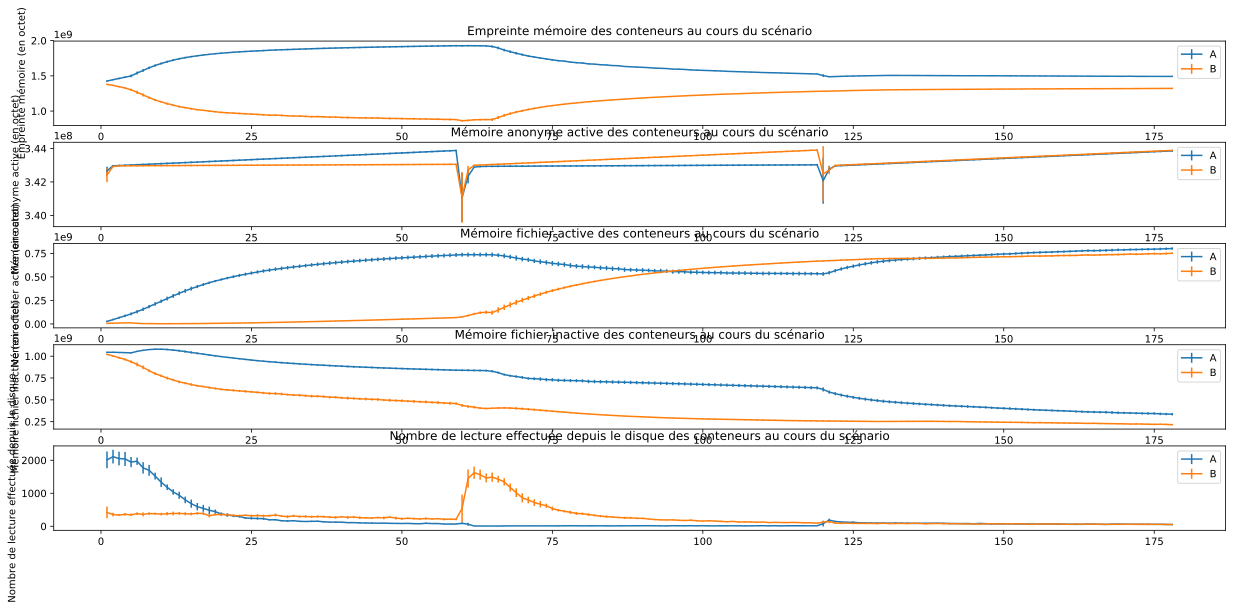

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats

NAMES = ['2GB/2GB']

DIR = 'update_soft_limit_5s'
FILES = {'A': ['soft_update_container_A_sad_feynman_2000M.stats.csv'], 'B': ['soft_update_container_B_keen_lalande_2000M.stats.csv']}

DURATION = 180

dictionnary = {}

for key in FILES:
    dictionnary[key] = {'usage': {}, 'active_anon': {}, 'active_file': {}, 'inactive_file': {}, 'reads': {}}
    
for key in FILES:
    for file in FILES[key]:
        # Get data from CSV file.
        df = pd.read_csv(DIR + '/' + file, ';')
        values = df.values

        # The first record has strange standard deviation values so we do not get it.
        dictionnary[key]['usage']['means'] =values.take(1, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['usage']['stds'] = values.take(2, axis = 1)[1 : len(values) - 1]

        dictionnary[key]['active_anon']['means'] = values.take(3, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['active_anon']['stds'] = values.take(4, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['active_file']['means'] = values.take(5, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['active_file']['stds'] = values.take(6, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['inactive_file']['means'] = values.take(9, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['inactive_file']['stds'] = values.take(10, axis = 1)[1 : len(values) - 1]
        
        dictionnary[key]['reads']['means'] = values.take(13, axis = 1)[1 : len(values) - 1]
        dictionnary[key]['reads']['stds'] = values.take(14, axis = 1)[1 : len(values) - 1]

# xtick labels for the bar chart.
x_pos = np.arange(len(range(DURATION)))

fig, (usage_ax, active_anon_ax, active_file_ax, inactive_file_ax, reads_ax) = plt.subplots(nrows = 5, figsize = (21, 9))

for key in sorted(FILES.keys()):
    for i in range(len(NAMES)):
        usage_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['usage']['means'], yerr = dictionnary[key]['usage']['stds'], label = key)
        active_anon_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['active_anon']['means'], yerr = dictionnary[key]['active_anon']['stds'], label = key)
        active_file_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['active_file']['means'], yerr = dictionnary[key]['active_file']['stds'], label = key)
        inactive_file_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['inactive_file']['means'], yerr = dictionnary[key]['inactive_file']['stds'], label = key)
        reads_ax.errorbar(x_pos[1 : len(x_pos) - 1], dictionnary[key]['reads']['means'], yerr = dictionnary[key]['reads']['stds'], label = key)

usage_ax.legend()
usage_ax.set_ylabel('Empreinte mémoire (en octet)')
usage_ax.set_title('Empreinte mémoire des conteneurs au cours du scénario')

active_anon_ax.legend()
active_anon_ax.set_ylabel('Mémoire anonyme active (en octet)')
active_anon_ax.set_title('Mémoire anonyme active des conteneurs au cours du scénario')

active_file_ax.legend()
active_file_ax.set_ylabel('Mémoire fichier active (en octet)')
active_file_ax.set_title('Mémoire fichier active des conteneurs au cours du scénario')

inactive_file_ax.legend()
inactive_file_ax.set_ylabel('Mémoire fichier inactive (en octet)')
inactive_file_ax.set_title('Mémoire fichier inactive des conteneurs au cours du scénario')

reads_ax.legend()
reads_ax.set_ylabel('Nombre de lecture effectuée depuis le disque')
reads_ax.set_title('Nombre de lecture effectuée depuis le disque des conteneurs au cours du scénario')

# Print the figure.
set_matplotlib_formats('svg')
plt.show()

On peut clairement voir les moments où la `soft` limite est mise à jour. Notamment pour le conteneur A.
Cette mise à jour lui permet d'atteindre une empreinte mémoire d'environ 2GB soit la taille de la base de données qu'il manipule.

Concernant le nombre de lectures effectuées depuis le disque ce changement permet de faire chuter celles-ci un peu plus rapidement.
Ce comportement explique donc la latence moins élevée et les performances améliorées.

#### Conclusion
La mise à jour de la `soft` limite au cours de l'expérience permet aux conteneurs de gagner légèrement en performance.